In [1]:
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import sparse

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

In [2]:
figsize = (7.5, 6)
fig_dir = 'figs/modeling/Champaign/'

In [3]:
# Load data

data_dir = 'data/Champaign/'
dfb = pd.read_csv(data_dir + 'business.csv', encoding='latin-1')
dfr = pd.read_csv(data_dir + 'review.csv', encoding='latin-1')
dfu = pd.read_csv(data_dir + 'user.csv', encoding='latin-1')
datar = pd.read_csv(data_dir + 'data_review.csv', encoding='latin-1')

In [4]:
print(dfb.shape)
print(dfu.shape)
print(datar.shape)
datar.head()

(1084, 101)
(9142, 22)
(24088, 3)


,user_id,business_id,stars
0,94431,56,2
1,397042,56,1
2,259145,56,3
3,412466,56,1
4,84515,57,4


In [5]:
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.5, random_state=0)

In [6]:
def norm_cm(cm):
    cm = deepcopy(cm).astype(float)
    for i in range(len(cm)):
        cm[i, :] = cm[i, :] / np.sum(cm[i, :])
    return cm  

def plot_cm(cm, title='', file_name=None):
    
    # Reference:
    # https://github.com/kevin11h/YelpDatasetChallengeDataScienceAndMachineLearningUCSD
    
    cm = norm_cm(cm)
    c = plt.pcolor(cm, edgecolors='k', linewidths=4, cmap='jet', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual target label')
    plt.xlabel('Predicted target label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))
    
    def show_values(pc, fmt="%.2f", **kw):
        pc.update_scalarmappable()
        for p, value in zip(pc.get_paths(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if value >= 0.3 and value <= 0.85:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            plt.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)
    
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')


### Baseline model 1: estimating biases with sample averages

$$\hat{Y}_{um}^{baseline1} = \mu + \bar{\theta}_u + \bar{\gamma}_m$$

In [7]:
class BaselineMean(BaseEstimator):
    def __init__(self, classification=False):
        self.fitted = False
        self.classification = classification
        self.time_fitting = []
        self.time_predict = []
    
    def _fit_id2index(self, X):
        self._user_id_array = np.unique(X[:, 0])
        self._user_id_dict = {self._user_id_array[i]:i for i in range(len(self._user_id_array))}
        self._bus_id_array = np.unique(X[:, 1])
        self._bus_id_dict = {self._bus_id_array[i]:i for i in range(len(self._bus_id_array))}
        self.n_u = len(self._user_id_array)
        self.n_m = len(self._bus_id_array)
        self.n_bp = self.n_u + self.n_m + 1
        return self
        
    def _transform_id2index(self, X):
        X = deepcopy(X)
        X[:, 0] = np.array([self._user_id_dict.get(x, -1) for x in X[:, 0]])
        X[:, 1] = np.array([self._bus_id_dict.get(x, -1) for x in X[:, 1]])
        return X
    
    def _fit_transform_id2index(self, X):
        self._fit_id2index(X)
        X = self._transform_id2index(X)
        return X
    
    def _fit_baseline_mean(self, X, y):
        self.mean_global = np.mean(y)
        self.df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        self.mean_user_bias = self.df[[0, 2]].groupby(0, as_index=False).mean().sort_values(by=0)[2].values - self.mean_global
        self.mean_bus_bias = self.df[[1, 2]].groupby(1, as_index=False).mean().sort_values(by=1)[2].values - self.mean_global
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        self._fit_baseline_mean(X, y)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]] + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_bus_bias[x_i[1]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        def _predict_x(x_i):
            return self.mean_global + self.mean_user_bias[x_i[0]]
        y_pred = np.apply_along_axis(_predict_x, 1, X)
        return y_pred
        
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.mean_global * np.ones(len(X))
    
    def _predict_baseline(self, X):
        y_pred = np.zeros(len(X))
        no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
        user_missing = np.logical_and(X[:, 0] == -1, X[:, 1] != -1)
        bus_missing = np.logical_and(X[:, 0] != -1, X[:, 1] == -1)
        all_missing = np.logical_and(X[:, 0] == -1, X[:, 1] == -1)
        y_pred[no_missing] = self._predict_no_missing(X[no_missing])
        y_pred[user_missing] = self._predict_user_missing(X[user_missing])
        y_pred[bus_missing] = self._predict_bus_missing(X[bus_missing])
        y_pred[all_missing] = self._predict_all_missing(X[all_missing])
        return y_pred
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        return self._predict_baseline(X)
    
    def _predict_classification(self, X):
        y = self._predict_regression(X)
        y = np.round(y)
        y[y < 1] = 1
        y[y > 5] = 5
        return y.astype(int)
    
    def predict(self, X, classification=None):
        t0 = time.time()
        if not self.fitted:
            raise ValueError('Estimator not fitted.')
        if classification is None:
            classification = self.classification
        if not classification:
            results = self._predict_regression(X)
        else:
            results = self._predict_classification(X)
        self.time_predict.append(time.time() - t0)
        return results
        
    
    def score(self, X, y, classification=None, scoring='r2'):
        if classification is None:
            classification = self.classification
        if not classification:
            if scoring == 'r2':
                return r2_score(y, self.predict(X, classification))
            elif scoring == 'mse':
                return mean_squared_error(y, self.predict(X, classification))
            elif scoring == 'rmse':
                return np.sqrt(mean_squared_error(y, self.predict(X, classification)))
            else:
                raise NotImplementedError('`scoring` should be either "r2", "mse", or "rmse".')
        else:
            return accuracy_score(y, self.predict(X, classification))

In [8]:
bm = BaselineMean().fit(X_train, y_train)
model_name = 'Baseline model 1 (estimating biases with sample averages)'
print(model_name + ':')
print('Fitting time: {} s.'.format(bm.time_fitting[-1]))
print('RMSE on training set: {}.'.format(bm.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(bm.score(X_test, y_test, scoring='rmse')))

Baseline model 1 (estimating biases with sample averages):
Fitting time: 0.015600204467773438 s.
RMSE on training set: 0.9552630799576178.
RMSE on test set: 1.4735772927251958.


Root mean squared error (RMSE) on the test set is much higher than that on the training set, indicating overfitting occurs.

We can also interpret the prediction of this recommender system as a classification problem by rounding the predicted values to closest labels. We can calculate the classification accuracy and plot the confusion matrix.

Baseline model 1 (estimating biases with sample averages):
Classification accuracy on training set: 0.5677515775489871.
Classification accuracy on test set: 0.3182497509133178.


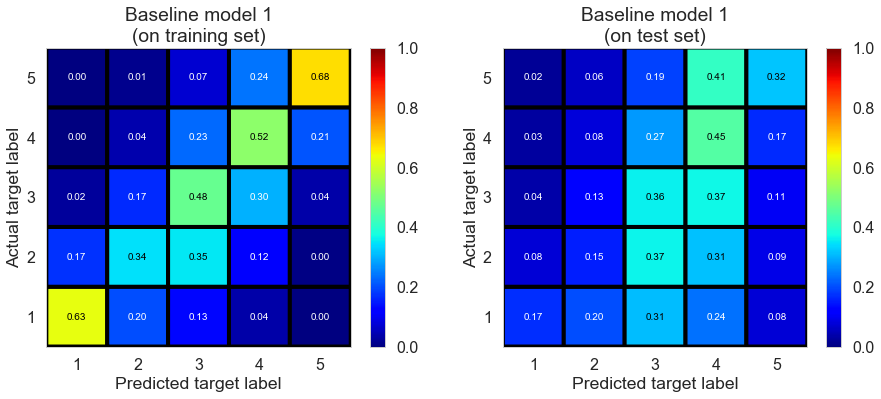

In [9]:
print(model_name + ':')
print('Classification accuracy on training set: {}.'.format(bm.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm.score(X_test, y_test, classification=True)))

y_pred_train_label = bm.predict(X_train, classification=True)
y_pred_test_label = bm.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 1\n(on training set)')
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 1\n(on test set)')

plt.savefig(fig_dir + 'bm1_cm.png', bbox_inches='tight')

The performance of baseline model 1 (based on estimating biases with sample averages) is not too bad.

### Baseline model 2: estimating biases using regularized regression

$$\hat{Y}_{um}^{baseline2} = \mu + \bar{\theta}\cdot I_u + \bar{\gamma}\cdot I_m$$

To save computation time, we use Ridge regression instead of Lasso regression.

In [10]:
class BaselineRegression(BaselineMean):
    def __init__(self, alpha=0, classification=False):
        super().__init__(classification)
        self.alpha = alpha
        
    def _sparse_matrix_baseline_regression(self, X, cols=[0, 1]):
        I = np.concatenate([np.arange(len(X)) for _ in range(len(cols) + 1)]).astype(int)
        J = np.zeros(len(X), dtype=int)
        if 0 in cols:
            J = np.concatenate((J, X[:, 0] + 1)).astype(int)
        if 1 in cols:
            J = np.concatenate((J, X[:, 1] + 1 + self.n_u)).astype(int)
        V = np.ones((len(cols) + 1) * len(X))
        A = sparse.coo_matrix((V, (I, J)), shape=(len(X), self.n_bp))
        return A
    
    def _fit_baseline_regression(self, X, y):
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        self.params_base = sparse.linalg.lsmr(A, y, damp=self.alpha)[0]
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        self._fit_baseline_regression(X, y)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_no_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0, 1])
        return A.dot(self.params_base)
    
    def _predict_user_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[1])
        return A.dot(self.params_base)
    
    def _predict_bus_missing(self, X):
        if len(X) == 0:
            return np.array([])
        A = self._sparse_matrix_baseline_regression(X, cols=[0])
        return A.dot(self.params_base)
    
    def _predict_all_missing(self, X):
        if len(X) == 0:
            return np.array([])
        return self.params_base[0] * np.ones(len(X))

We can determine the regularization parameter $\alpha$ through cross-validation.

We can either interpret the system as a regression question and evaluate the results through `neg_mean_squared_error`, or interpret it as a classification question and evluate the classification accuracy.

In [11]:
alphas = [10**(i-5) for i in range(8)]
gs1 = GridSearchCV(BaselineRegression(classification=False), param_grid={'alpha':alphas}, scoring='neg_mean_squared_error', \
                  cv=5, return_train_score=True).fit(X_train, y_train)
gs2 = GridSearchCV(BaselineRegression(classification=True), param_grid={'alpha':alphas}, scoring='accuracy', \
                  cv=5, return_train_score=True).fit(X_train, y_train)

The best alpha (for regression question) determined through cross-validation is 1.
The best alpha (for classification question) determined through cross-validation is 1e-05.


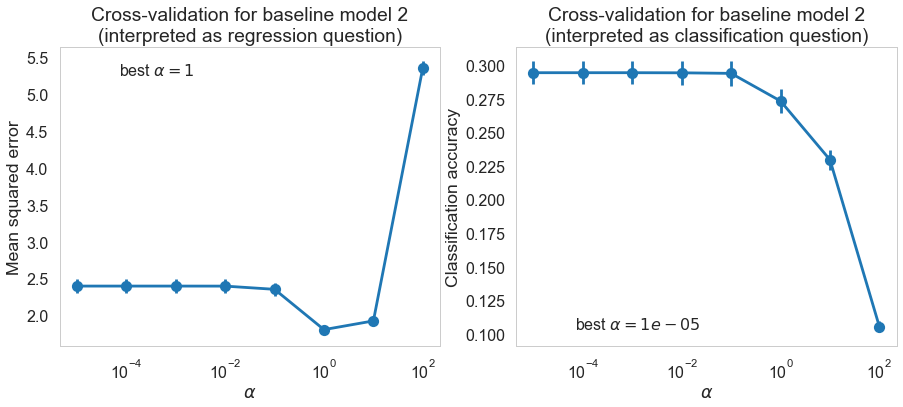

In [12]:
best_alpha1 = alphas[np.argmax(gs1.cv_results_['mean_test_score'])]
print('The best alpha (for regression question) determined through cross-validation is {}.'.format(best_alpha1))

best_alpha2 = alphas[np.argmax(gs2.cv_results_['mean_test_score'])]
print('The best alpha (for classification question) determined through cross-validation is {}.'.format(best_alpha2))

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.errorbar(alphas, -gs1.cv_results_['mean_test_score'], gs1.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas, -gs1.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha1));
plt.xlabel(r'$\alpha$');
plt.ylabel('Mean squared error');
plt.legend();
plt.title('Cross-validation for baseline model 2\n(interpreted as regression question)');

plt.subplot(1, 2, 2)
plt.errorbar(alphas, gs2.cv_results_['mean_test_score'], gs2.cv_results_['std_test_score'], fmt='o-');
plt.semilogx(alphas, gs2.cv_results_['mean_test_score'], alpha=0, label=r'best $\alpha = {}$'.format(best_alpha2));
plt.xlabel(r'$\alpha$');
plt.ylabel('Classification accuracy');
plt.legend();
plt.title('Cross-validation for baseline model 2\n(interpreted as classification question)');

plt.savefig(fig_dir + 'bm2_cv_alpha.png', bbox_inches='tight')

As we can see, the best $\alpha$s determined by cross-validation under 2 interpretations are very close. We can build the baseline model 2 using the determined regularization parameters and test its performance on training and test sets.

Baseline model 2 (estimating biases using regularized regression):
(alpha = 1)
Fitting time: 0.030002117156982422 s.
RMSE on training set: 0.8560891318570681.
RMSE on test set: 1.331283324552174.

Classification accuracy on training set: 0.4459481899701096.
Classification accuracy on test set: 0.27299900365327134.


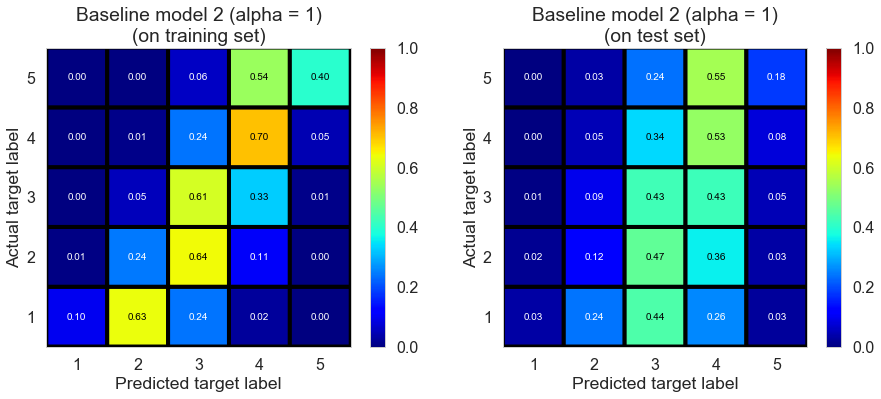

In [13]:
alpha = best_alpha1

bm2 = BaselineRegression(alpha=alpha).fit(X_train, y_train)
print('Baseline model 2 (estimating biases using regularized regression):')
print('(alpha = {})'.format(alpha))
print('Fitting time: {} s.'.format(bm2.time_fitting[-1]))
print('RMSE on training set: {}.'.format(bm2.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(bm2.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(bm2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm2.score(X_test, y_test, classification=True)))

y_pred_train_label = bm2.predict(X_train, classification=True)
y_pred_test_label = bm2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 2 (alpha = {})\n(on training set)'.\
        format(alpha))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 2 (alpha = {})\n(on test set)'.\
        format(alpha))

plt.savefig(fig_dir + 'bm2_cm_alpha1.png', bbox_inches='tight')

Interstingly, the RMSE is better than that of baseline model 1 on both training and test sets, while the classification accuracy is worse.

Baseline model 2 (estimating biases using regularized regression):
(alpha = 1e-05)
Fitting time: 0.08060359954833984 s.
RMSE on training set: 0.7191584764911071.
RMSE on test set: 1.5161869201652816.

Classification accuracy on training set: 0.6565094652939223.
Classification accuracy on test set: 0.29981733643307873.


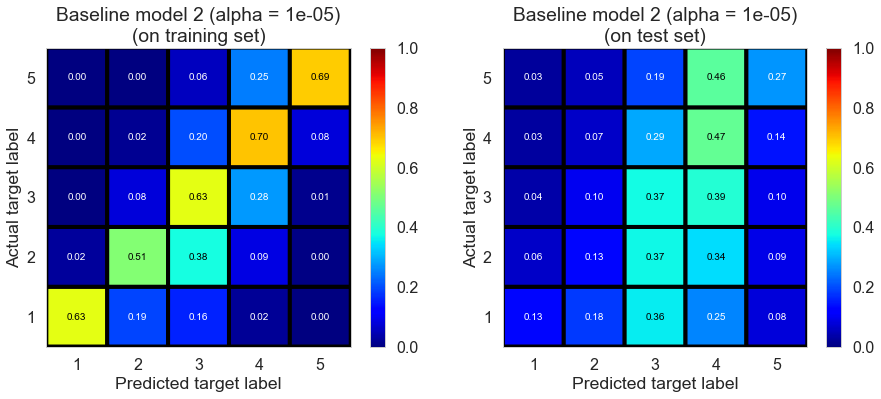

In [14]:
alpha = best_alpha2

bm2 = BaselineRegression(alpha=alpha).fit(X_train, y_train)
print('Baseline model 2 (estimating biases using regularized regression):')
print('(alpha = {})'.format(alpha))
print('Fitting time: {} s.'.format(bm2.time_fitting[-1]))
print('RMSE on training set: {}.'.format(bm2.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(bm2.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(bm2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(bm2.score(X_test, y_test, classification=True)))

y_pred_train_label = bm2.predict(X_train, classification=True)
y_pred_test_label = bm2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'Baseline model 2 (alpha = {})\n(on training set)'.\
        format(alpha))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'Baseline model 2 (alpha = {})\n(on test set)'.\
        format(alpha))

plt.savefig(fig_dir + 'bm2_cm_alpha2.png', bbox_inches='tight')

Performance on training set is better than that of baseline model 1, but it is worse on test set, indicating more serious overfitting for this smaller regularization parameter.

### Collaborative filtering model 1: explicit matrix factorization using alternating least squares (ALS)

$$r_{um} = Y_{um} - \hat{Y}_{um}^{baseline2}$$

$$\hat{r}_{um} = \bar{q}_m^T\cdot \bar{p}_u$$

We try 2 strategies here:
1. We can try a greedy strategy where we first learn the baseline model and then apply alternating least squares on the residues of baseline model.
2. We can learn the bias terms together with latent factor coefficients in each iteration.

#### Strategy 1 (not updating biases in each iteration)

In [15]:
class ALS(BaselineRegression):
    def __init__(self, alpha=1, rank=100, iterations=10, init_mean=0, init_std=0.1, \
                 random_state=0, classification=False):
        super().__init__(alpha, classification)
        self.rank = rank
        self.iterations = iterations
        self.init_mean = init_mean
        self.init_std = init_std
        self.random_state = random_state
    
    def _fit_ALS_u2m(self):
        self.params_m = np.array([sparse.linalg.lsmr(self.params_u[self.X_u2m[self.ind_u2m[i]:self.ind_u2m[i+1], 0]], \
                                                     self.y_u2m[self.ind_u2m[i]:self.ind_u2m[i+1]], damp=self.alpha)[0] \
                                  for i in range(self.n_m)])
        return self
    
    def _fit_ALS_m2u(self):
        self.params_u = np.array([sparse.linalg.lsmr(self.params_m[self.X_m2u[self.ind_m2u[i]:self.ind_m2u[i+1], 1]], \
                                                     self.y_m2u[self.ind_m2u[i]:self.ind_m2u[i+1]], damp=self.alpha)[0] \
                                  for i in range(self.n_u)])
        return self
        
    def _fit_ALS(self, X, y):
        df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        df_u2m = df.sort_values(by=[1, 0]).values
        self.X_u2m = df_u2m[:, :2].astype(int)
        self.y_u2m = df_u2m[:, 2]
        self.ind_u2m = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_u2m[:, 1], minlength=self.n_m))))
        df_m2u = df.sort_values(by=[0, 1]).values
        self.X_m2u = df_m2u[:, :2].astype(int)
        self.y_m2u = df_m2u[:, 2]
        self.ind_m2u = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_m2u[:, 0], minlength=self.n_u))))
        np.random.seed(self.random_state)
        self.params_u = np.random.normal(self.init_mean, self.init_std, (self.n_u, self.rank))
        for _ in range(self.iterations):
            self._fit_ALS_u2m()
            self._fit_ALS_m2u()
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        y_base = self._fit_baseline_regression(X, y)._predict_no_missing(X)
        self._fit_ALS(X, y-y_base)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_ALS(self, X):
        return np.array([self.params_u[X[i, 0]].dot(self.params_m[X[i, 1]]) for i in range(len(X))])
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        y = self._predict_baseline(X)
        if self.iterations > 0:
            no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
            y[no_missing] = y[no_missing] + self._predict_ALS(X[no_missing])
        return y

First, we can gain some intuition about the impact of the number of iterations on the training and test performance. We could use the regularization factor identified for the baseline model.

In [16]:
iterations = [0, 5, 10, 15]
alss = [ALS(alpha=best_alpha1, iterations=i, rank=100).fit(X_train, y_train) for i in iterations]

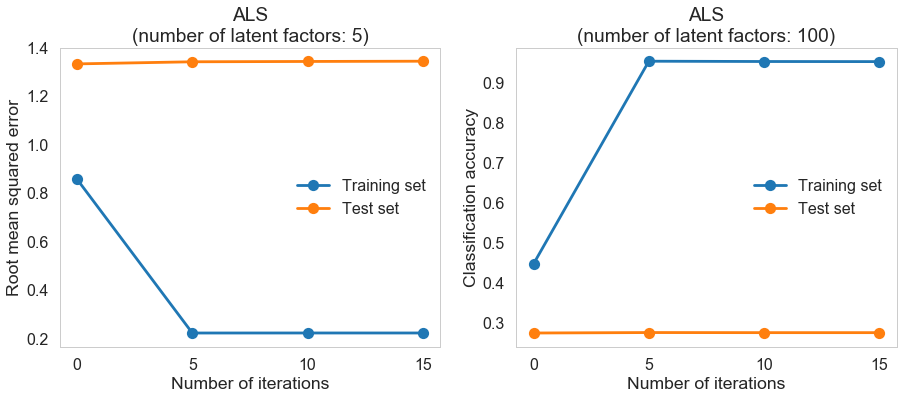

In [17]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in alss]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in alss]
train_accuracy = [a.score(X_train, y_train, classification=True) for a in alss]
test_accuracy = [a.score(X_test, y_test, classification=True) for a in alss]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(iterations, train_rmse, 'o-', label='Training set');
plt.plot(iterations, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Root mean squared error');
plt.title('ALS\n(number of latent factors: {})'.format(5))
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(iterations, train_accuracy, 'o-', label='Training set');
plt.plot(iterations, test_accuracy, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Classification accuracy');
plt.title('ALS\n(number of latent factors: {})'.format(100))
plt.legend();

plt.savefig(fig_dir + 'als_iterations.png', bbox_inches='tight')

The performance on the training set improves significantly compared to baseline model; the performance on the test set decreases slightly as the number of iterations increases, indicating the occurrence of overfitting. The performance doesn't change much as we increase the number of iterations from 5 to 10 and 15, suggesting 5 iterations could be enough.

We can fix the number of iterations to 5, and gain some intuition about the impact of number of latent factors on the performance.

In [18]:
ranks = [0, 5, 10, 20, 50, 100, 200]
alss2 = [ALS(alpha=best_alpha1, rank=r, iterations=10).fit(X_train, y_train) for r in ranks]

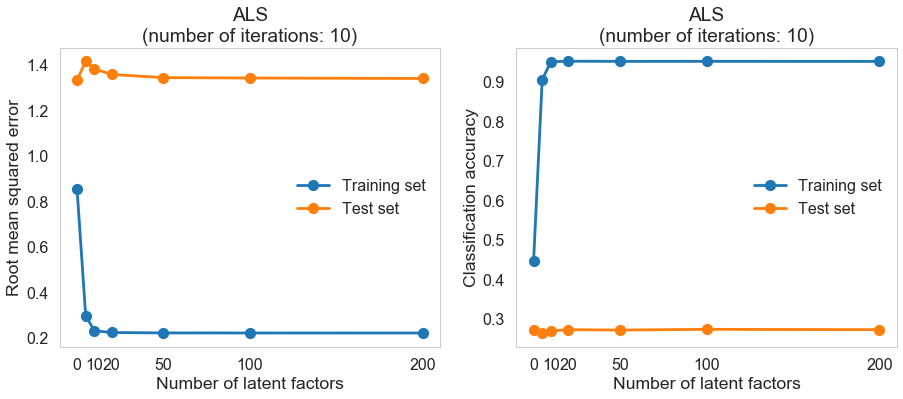

In [19]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in alss2]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in alss2]
train_accuracy = [a.score(X_train, y_train, classification=True) for a in alss2]
test_accuracy = [a.score(X_test, y_test, classification=True) for a in alss2]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(ranks, train_rmse, 'o-', label='Training set');
plt.plot(ranks, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Root mean squared error');
plt.title('ALS\n(number of iterations: {})'.format(10))
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(ranks, train_accuracy, 'o-', label='Training set');
plt.plot(ranks, test_accuracy, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Classification accuracy');
plt.title('ALS\n(number of iterations: {})'.format(10))
plt.legend();

plt.savefig(fig_dir + 'als_ranks.png', bbox_inches='tight')

Collaberative filtering using ALS improves training performance significantly. Small number of latent factors increases the variance of the model, indicated by poor test performace; test performance is similar to baseline model when the number of latent factors is high.

In [20]:
alpha = best_alpha1
iterations = 10
rank = 100

als = ALS(alpha=alpha, iterations=iterations, rank=rank).fit(X_train, y_train)

ALS:
(alpha = 1, iterations = 10, rank = 100)
Fitting time: 23.527086973190308 s.
RMSE on training set: 0.22223612605998444.
RMSE on test set: 1.3413213297764621.

Classification accuracy on training set: 0.9516771836599136.
Classification accuracy on test set: 0.2739123214878778.


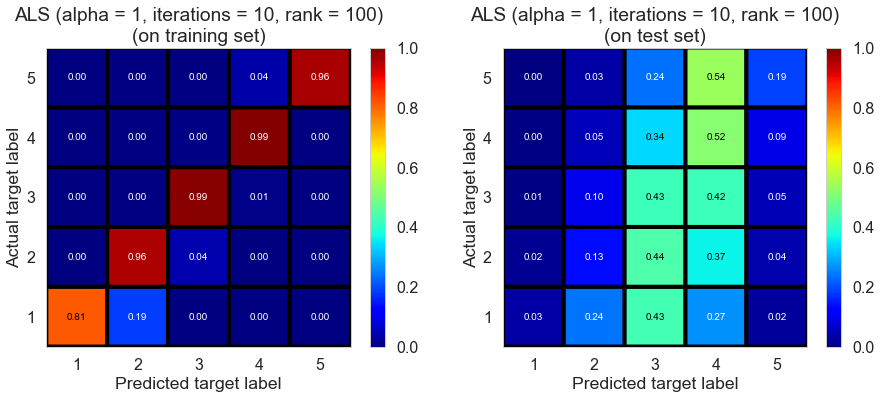

In [21]:
print('ALS:')
print('(alpha = {}, iterations = {}, rank = {})'.format(alpha, iterations, rank))
print('Fitting time: {} s.'.format(als.time_fitting[-1]))
print('RMSE on training set: {}.'.format(als.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(als.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(als.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(als.score(X_test, y_test, classification=True)))

y_pred_train_label = als.predict(X_train, classification=True)
y_pred_test_label = als.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on training set)'.\
        format(alpha, iterations, rank))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on test set)'.\
        format(alpha, iterations, rank))

plt.savefig(fig_dir + 'als_cm1.png', bbox_inches='tight')

#### Strategy 2 (updating biases in each iteration)

In [22]:
class ALS2(BaselineRegression):
    def __init__(self, alpha=1, rank=100, iterations=10, init_mean=0, init_std=0.1, \
                 random_state=0, classification=False):
        super().__init__(alpha, classification)
        self.rank = rank
        self.iterations = iterations
        self.init_mean = init_mean
        self.init_std = init_std
        self.random_state = random_state
    
    def _fit_ALS_u2m(self):
        y_u2m = self.y_u2m - self.params_base[1 + self.X_u2m[:, 0]]
        params_m = np.array([sparse.linalg.lsmr(np.concatenate((np.ones((self.ind_u2m[i+1]-self.ind_u2m[i], 1)), \
                                                                self.params_u\
                                                                [self.X_u2m[self.ind_u2m[i]:self.ind_u2m[i+1], 0]]), axis=1), \
                                                y_u2m[self.ind_u2m[i]:self.ind_u2m[i+1]], \
                                                damp=self.alpha)[0] for i in range(self.n_m)])
        self.params_base[1+self.n_u:] = params_m[:, 0]
        self.params_m = params_m[:, 1:]
        return self
    
    def _fit_ALS_m2u(self):
        y_m2u = self.y_m2u - self.params_base[1 + self.n_u + self.X_m2u[:, 1]]
        params_u = np.array([sparse.linalg.lsmr(np.concatenate((np.ones((self.ind_m2u[i+1]-self.ind_m2u[i], 1)), \
                                                                self.params_m\
                                                                [self.X_m2u[self.ind_m2u[i]:self.ind_m2u[i+1], 1]]), axis=1), \
                                                y_m2u[self.ind_m2u[i]:self.ind_m2u[i+1]], \
                                                damp=self.alpha)[0] for i in range(self.n_u)])
        self.params_base[1:1+self.n_u] = params_u[:, 0]
        self.params_u = params_u[:, 1:]
        return self
        
    def _fit_ALS(self, X, y):
        df = pd.DataFrame(np.concatenate((X, y.reshape(-1, 1)), axis=1))
        df_u2m = df.sort_values(by=[1, 0]).values
        self.X_u2m = df_u2m[:, :2].astype(int)
        self.y_u2m = df_u2m[:, 2]
        self.ind_u2m = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_u2m[:, 1], minlength=self.n_m))))
        df_m2u = df.sort_values(by=[0, 1]).values
        self.X_m2u = df_m2u[:, :2].astype(int)
        self.y_m2u = df_m2u[:, 2]
        self.ind_m2u = np.concatenate((np.zeros(1, dtype=int), \
                                       np.cumsum(np.bincount(self.X_m2u[:, 0], minlength=self.n_u))))
        np.random.seed(self.random_state)
        self.params_u = np.random.normal(self.init_mean, self.init_std, (self.n_u, self.rank))
        for _ in range(self.iterations):
            self._fit_ALS_u2m()
            self._fit_ALS_m2u()
        return self
    
    def fit(self, X, y):
        t0 = time.time()
        X = self._fit_transform_id2index(X)
        self._fit_baseline_regression(X, y)
        self._fit_ALS(X, y-self.params_base[0])
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_ALS(self, X):
        return np.array([self.params_u[X[i, 0]].dot(self.params_m[X[i, 1]]) for i in range(len(X))])
    
    def _predict_regression(self, X):
        X = self._transform_id2index(X)
        y = self._predict_baseline(X)
        if self.iterations > 0:
            no_missing = np.logical_and(X[:, 0] != -1, X[:, 1] != -1)
            y[no_missing] = y[no_missing] + self._predict_ALS(X[no_missing])
        return y

In [23]:
iterations = [0, 5, 10, 15]
als2s = [ALS2(alpha=best_alpha1, iterations=i).fit(X_train, y_train) for i in iterations]

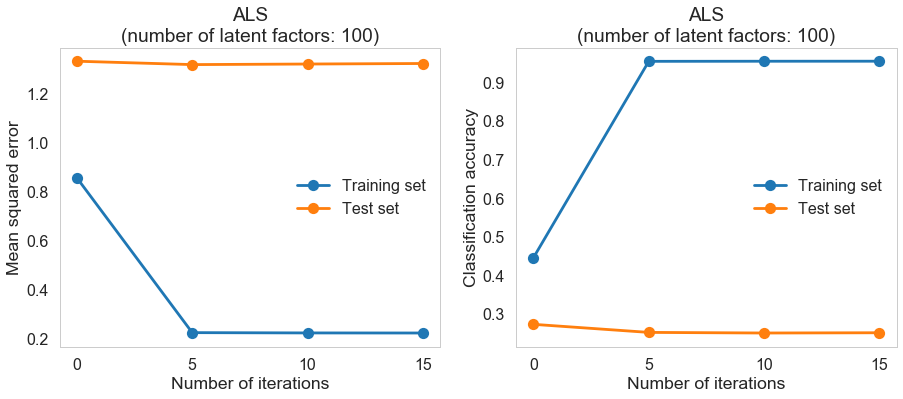

In [24]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in als2s]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in als2s]
train_accuracy = [a.score(X_train, y_train, classification=True) for a in als2s]
test_accuracy = [a.score(X_test, y_test, classification=True) for a in als2s]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(iterations, train_rmse, 'o-', label='Training set');
plt.plot(iterations, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Mean squared error');
plt.title('ALS\n(number of latent factors: {})'.format(100))
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(iterations, train_accuracy, 'o-', label='Training set');
plt.plot(iterations, test_accuracy, 'o-', label='Test set');
plt.xlabel('Number of iterations');
plt.xticks(iterations, iterations);
plt.ylabel('Classification accuracy');
plt.title('ALS\n(number of latent factors: {})'.format(100))
plt.legend();

plt.savefig(fig_dir + 'als2_iterations.png', bbox_inches='tight')

In [25]:
ranks = [0, 5, 10, 20, 50, 100, 200]
als2s2 = [ALS2(alpha=best_alpha1, rank=r, iterations=10).fit(X_train, y_train) for r in ranks]

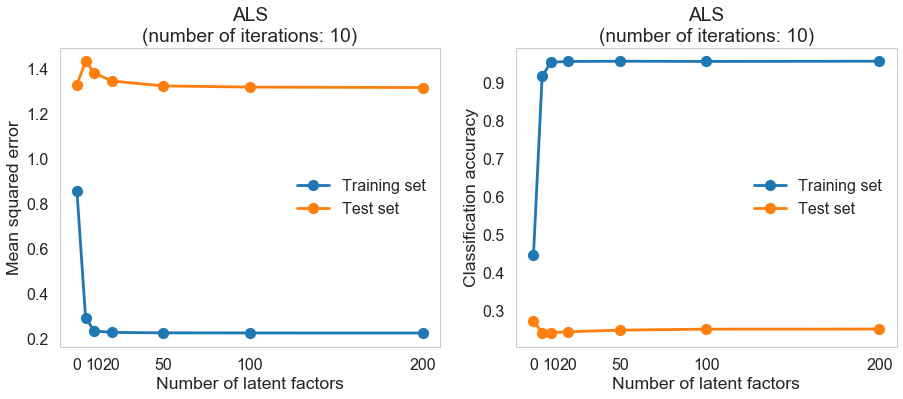

In [26]:
train_rmse = [a.score(X_train, y_train, scoring='rmse') for a in als2s2]
test_rmse = [a.score(X_test, y_test, scoring='rmse') for a in als2s2]
train_accuracy = [a.score(X_train, y_train, classification=True) for a in als2s2]
test_accuracy = [a.score(X_test, y_test, classification=True) for a in als2s2]

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plt.plot(ranks, train_rmse, 'o-', label='Training set');
plt.plot(ranks, test_rmse, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Mean squared error');
plt.title('ALS\n(number of iterations: {})'.format(10))
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(ranks, train_accuracy, 'o-', label='Training set');
plt.plot(ranks, test_accuracy, 'o-', label='Test set');
plt.xlabel('Number of latent factors');
plt.xticks([0] + ranks[2:], [0] + ranks[2:]);
plt.ylabel('Classification accuracy');
plt.title('ALS\n(number of iterations: {})'.format(10))
plt.legend();

plt.savefig(fig_dir + 'als2_ranks.png', bbox_inches='tight')

In [27]:
alpha = best_alpha1
iterations = 10
rank = 100

als2 = ALS2(alpha=alpha, iterations=iterations, rank=rank).fit(X_train, y_train)

ALS:
(alpha = 1, iterations = 10, rank = 100)
Fitting time: 25.861202478408813 s.
RMSE on training set: 0.2250910675639213.
RMSE on test set: 1.3198104730700038.

Classification accuracy on training set: 0.9551643972102292.
Classification accuracy on test set: 0.2504981733643308.


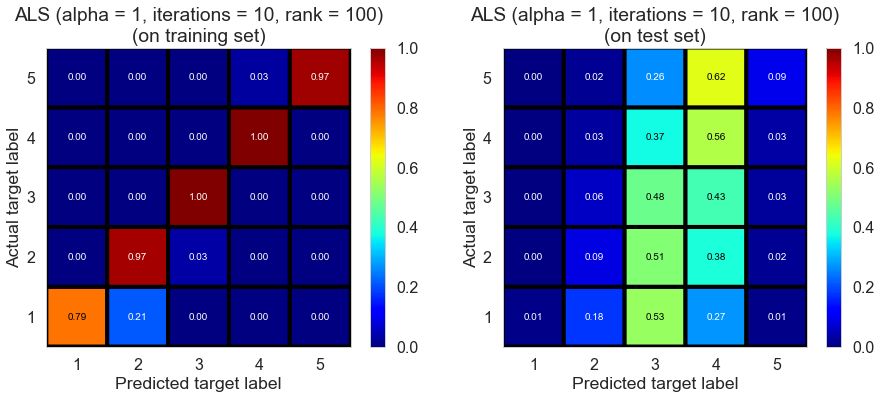

In [28]:
print('ALS:')
print('(alpha = {}, iterations = {}, rank = {})'.format(alpha, iterations, rank))
print('Fitting time: {} s.'.format(als2.time_fitting[-1]))
print('RMSE on training set: {}.'.format(als2.score(X_train, y_train, scoring='rmse')))
print('RMSE on test set: {}.'.format(als2.score(X_test, y_test, scoring='rmse')))
print()
print('Classification accuracy on training set: {}.'.format(als2.score(X_train, y_train, classification=True)))
print('Classification accuracy on test set: {}.'.format(als2.score(X_test, y_test, classification=True)))

y_pred_train_label = als2.predict(X_train, classification=True)
y_pred_test_label = als2.predict(X_test, classification=True)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_cm(confusion_matrix(y_train, y_pred_train_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on training set)'.\
        format(alpha, iterations, rank))
plt.subplot(1, 2, 2)
plot_cm(confusion_matrix(y_test, y_pred_test_label), 'ALS (alpha = {}, iterations = {}, rank = {})\n(on test set)'.\
        format(alpha, iterations, rank))

plt.savefig(fig_dir + 'als2_cm1.png', bbox_inches='tight')

The performance is very similar to that of previous strategy (without updating biases in each iteration).